# Lambert-based Impactor work 2

Yuri Shimane

2024/09/11

In [1]:
import numpy as np
import pykep as pk
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
from numba import njit

In [2]:
MU_MOON = 4902.8001            # km^3/s^2
LU = 1737.4                    # km
VU = np.sqrt(MU_MOON/LU)       # km/s
TU = LU/VU                     # sec
R_MOON = 1737.4                # km

mu = 1.0

In [3]:
from _lambert_impactor import *

In [4]:
get_impactor_transfer(mu, 1.1, 3.0, np.deg2rad(170), 1.0)

(array([-2.91616154,  0.51419796,  0.        ]),
 (-0.15416609727006644, -0.3931930962740776, 0.0),
 (-0.012514989294529218, 1.2258864766304296, 0.0),
 array([-0.01730179,  0.01775338,  0.        ]),
 10.448396961054673,
 array([0.99937918, 0.03049424]),
 True)

In [24]:
# we assume the perilune radius of orbiter to be fixed at 1 km
rp = (1737.4 + 100) / LU

# we make ra a variable
ra = (1737.4 + 20000) / LU

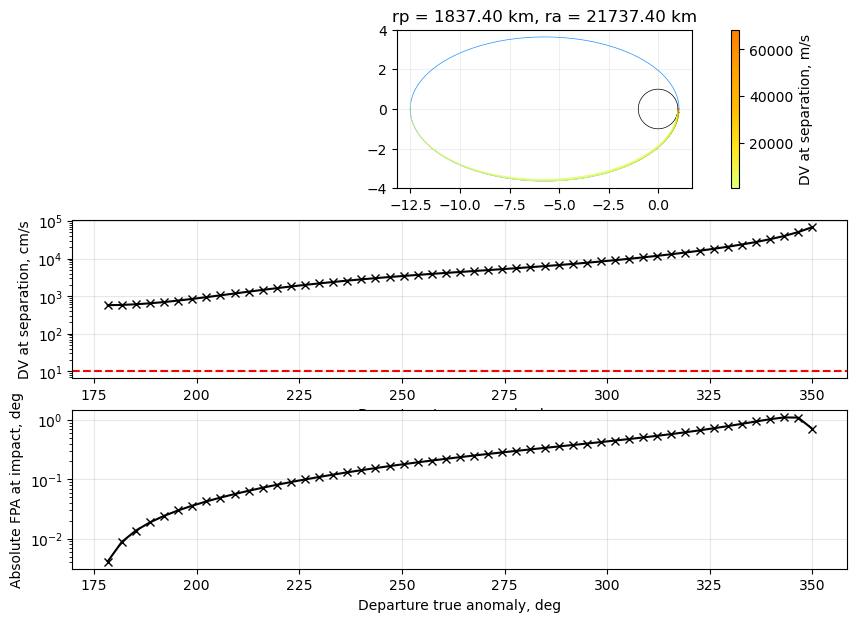

In [25]:
fig, axs = plt.subplots(3,1,figsize=(10,7))
# plot transfer
ax = axs[0]
ax.grid(True, alpha=0.2)
plot_circle([0,0], 1.0, ax)
steps = 1000
plot_perifocal_orbit(mu, rp, ra, ax=ax, steps=steps)

theta_dep_valid, rs_list, costs_dv, fpas_impact = [], [], [], []

for theta_dep in np.linspace(10,350,100):
    r1, v1_lamb, v2_lamb, DV1, tof, rp_vec_transfer, valid = get_impactor_transfer(
        mu, rp, ra, np.deg2rad(theta_dep), r_surface=1.0
    )
    if valid:
        rs_impactor, vs_impactor = get_transfer_history(mu,r1,v1_lamb,tof,steps=steps)
        fpa_impact = rv_to_fpa(rs_impactor[:,-1], vs_impactor[:,-1], mu)
        fpas_impact.append( fpa_impact )
        theta_dep_valid.append( theta_dep )
        rs_list.append( rs_impactor )
        costs_dv.append( np.linalg.norm(DV1) * VU * 1e5 )    # in km/s --> cm/s

for rs,cost in zip(rs_list, costs_dv):
    lc = get_lc_traj_singleColor(rs[0,:], rs[1,:], cost, min(costs_dv), max(costs_dv), "Wistia", lw=0.4)
    line = ax.add_collection(lc)
fig.colorbar(line, ax=ax, label="DV at separation, m/s")
ax.set_title(f"rp = {rp*LU:1.2f} km, ra = {ra*LU:1.2f} km")    
ax.set_aspect('equal')

ax = axs[1]
ax.grid(True, alpha=0.3)
ax.semilogy(theta_dep_valid, costs_dv, marker="x", color="k")
ax.axhline(10, color='red', ls='--')
ax.set(xlabel="Departure true anomaly, deg", ylabel="DV at separation, cm/s")

ax = axs[2]
ax.grid(True, alpha=0.3)
ax.semilogy(theta_dep_valid, np.abs(np.rad2deg(fpas_impact)), marker="x", color="k")
ax.set(xlabel="Departure true anomaly, deg", ylabel="Absolute FPA at impact, deg")
plt.show()